# 1. Install Dependencies and Setup

In [ ]:
#!pip install tensorflow opencv-python %matplotlib

In [2]:
#!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.3.3
fonttools                    4.39.3
gast                         0.4.0
google-auth                  2.17.3
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.54.0
h5py                         3.8.0
idna                         3.4
ipykernel                    6.22.0
ipython                      8.12.0
jax                          0.4.8
jedi 


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data_4' 

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [40]:
import numpy as np
from matplotlib import pyplot as plt

In [41]:
data = tf.keras.utils.image_dataset_from_directory('data_4')
class_names = data.class_names

Found 4000 files belonging to 4 classes.


In [42]:
data_iterator = data.as_numpy_iterator()

In [43]:
batch = data_iterator.next()

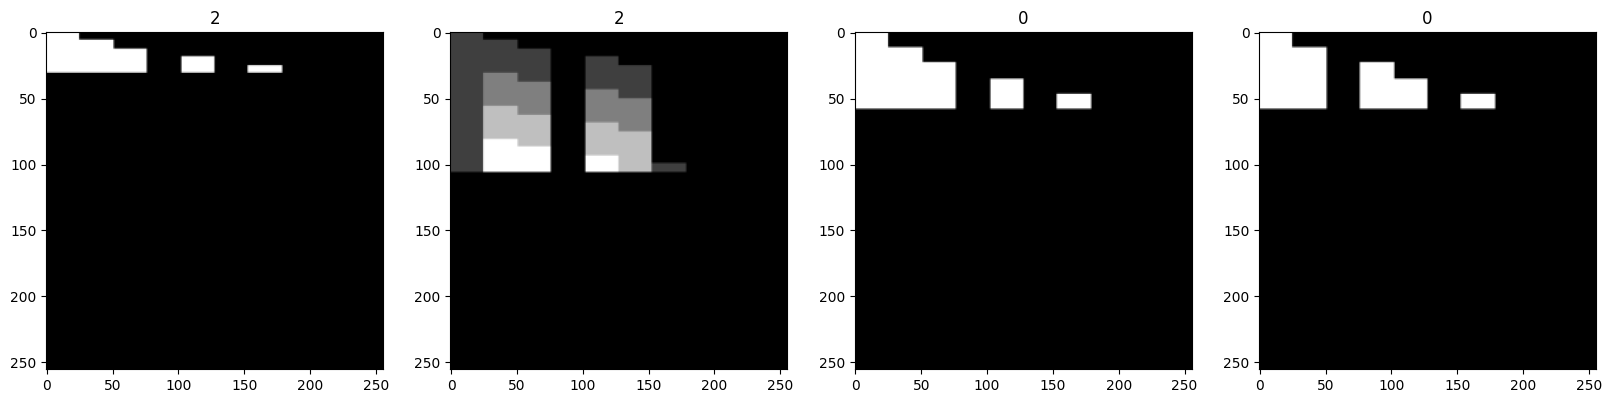

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [45]:
data = data.map(lambda x,y: (x/255, y))

In [46]:
data.as_numpy_iterator().next()

(array([[[[0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          [0.33333334, 0.33333334, 0.33333334],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# 5. Split Data

In [47]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [48]:
train_size

125

In [50]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# 6. Build Deep Learning Model

In [52]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [54]:
model = Sequential()

In [55]:
num_classes = 4

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))

In [56]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

# 7. Train

In [58]:
logdir='logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [60]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
87/87 [==============================] - 124s 1s/step - loss: 2.0753 - accuracy: 0.6638 - val_loss: 1.3591 - val_accuracy: 0.7550
Epoch 2/5
87/87 [==============================] - 110s 1s/step - loss: 1.4169 - accuracy: 0.7439 - val_loss: 1.3588 - val_accuracy: 0.7550
Epoch 3/5
87/87 [==============================] - 106s 1s/step - loss: 1.4195 - accuracy: 0.7435 - val_loss: 1.3587 - val_accuracy: 0.7550
Epoch 4/5
87/87 [==============================] - 110s 1s/step - loss: 1.4123 - accuracy: 0.7453 - val_loss: 1.3586 - val_accuracy: 0.7550
Epoch 5/5
87/87 [==============================] - 111s 1s/step - loss: 1.4123 - accuracy: 0.7453 - val_loss: 1.3586 - val_accuracy: 0.7550


# 8. Plot Performance

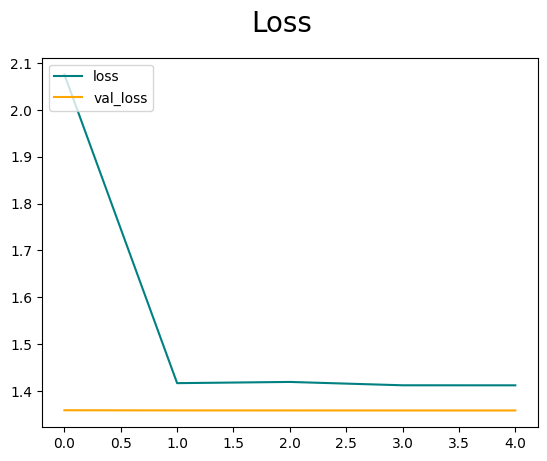

In [61]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

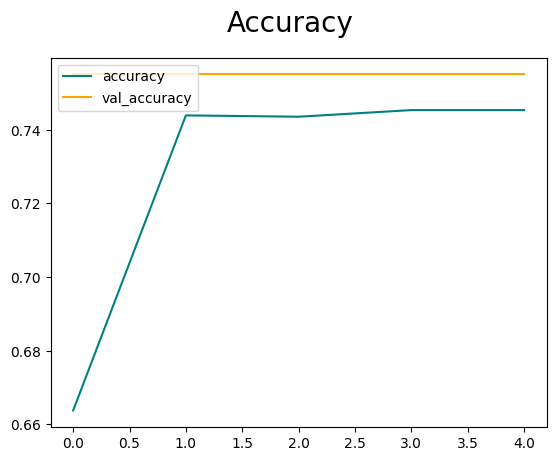

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [63]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [64]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [66]:
import cv2

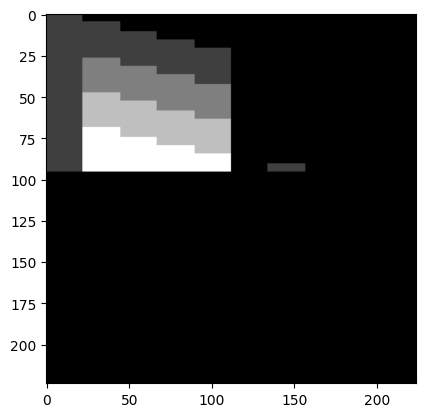

In [71]:
img = cv2.imread('direct_image_41.png')
plt.imshow(img)
plt.show()

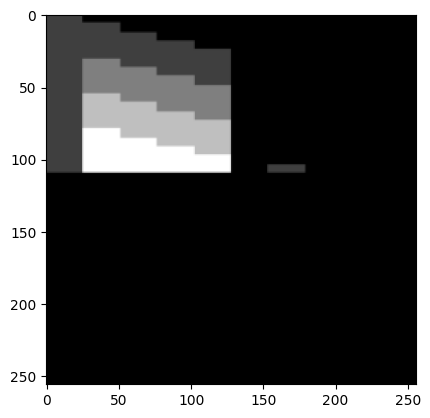

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [75]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 151ms/step


In [76]:
yhat

array([[ 2.8964794, 17.451065 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0. 

In [77]:
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(yhat)])
)

This image most likely belongs to pattern_direct.


# 11. Save the Model

In [78]:
from tensorflow.keras.models import load_model

In [79]:
model.save(os.path.join('models','pattern_model_4.h5'))

In [80]:
new_model = load_model(os.path.join('models','pattern_model_4.h5'))

In [81]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(yhat)])
)

1/1 [==============================] - 0s 139ms/step
This image most likely belongs to pattern_direct.
